In [ ]:
# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Corpus Processing
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import nltk.corpus
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

# GMM
from sklearn.mixture import GaussianMixture

# Visualization and Analysis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

[nltk_data] Downloading package stopwords to C:\Users\Ravi
[nltk_data]     Nadar\anaconda3\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Ravi
[nltk_data]     Nadar\anaconda3\lib\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data = pd.read_csv('national_anthems.csv', encoding='utf-8') #reading the dataset
data.columns = map(str.lower, data.columns)
data.head()

,country,alpha-2,alpha-3,continent,anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    190 non-null    object
 1   alpha-2    189 non-null    object
 2   alpha-3    190 non-null    object
 3   continent  190 non-null    object
 4   anthem     190 non-null    object
dtypes: object(5)
memory usage: 7.6+ KB


In [ ]:
data[data['alpha-2'].isna()]

,country,alpha-2,alpha-3,continent,anthem
168,Namibia,NaN,NAM,Africa,Namibia land of the brave Freedom fight we he ...


In [ ]:
data['alpha-2'].iloc[168] = "NA"  # link https://www.iban.com/country-codes
print(data[data['alpha-2'].isna()])

Empty DataFrame
Columns: [country, alpha-2, alpha-3, continent, anthem]
Index: []


In [ ]:
corpus_in_begining = data['anthem'].tolist()  # making a list of all anthems of 190 countries
len(corpus_in_begining)

190

In [ ]:
print(corpus_in_begining[97][0:]) #india's national anthem in english
print("-------------------")
print(corpus_in_begining[18][0:447]) #Hungary till 447th letter as it is long anthem

Thou art the ruler of the minds of all people, Dispenser of India's destiny. Thy name rouses the hearts of Punjab, Sindh,  Gujarat and Maratha, Of the Dravida and Odisha and Bengal; It echoes in the hills of Vindhya and the Himalayas, Mingles in the music of Ganga and Yamuna and is chanted by The waves of the Indian sea. They pray for thy blessings and sing thy praise. The saving of all people waits in thy hand, Thou dispenser of India's destiny. Victory, victory, victory to thee
-------------------
O Lord, bless the nation of Hungary With your grace and bounty Extend over it your guarding arm During strife with its enemies Long torn by ill fate Bring upon it a time of relief This nation has suffered for all sins Of the past and of the future! You brought our ancestors up Over the Carpathians' holy peaks By You was won a beautiful homeland For Bendeguz's sons And wherever flow the rivers of The Tisza and the Danube ÃƒÂrpÃƒÂ¡d our hero's 


In [ ]:
# removes a list of words (ie. stopwords) from a tokenized list.
def remove_words(list_of_tokens, list_of_words):
    return [token for token in list_of_tokens if token not in list_of_words]

# applies stemming to a list of tokenized words
def apply_stemming(list_of_tokens, stemmer):
    return [stemmer.stem(token) for token in list_of_tokens]

# removes any words composed of less than 2 or more than 21 letters
def two_or_22_letters(list_of_tokens):
    two_or_22_letter_word = []
    for token in list_of_tokens:
        if len(token) <= 2 or len(token) >= 21:
            two_or_22_letter_word.append(token)
    return two_or_22_letter_word

In [ ]:
def prepare_corpus(corpus, language):
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    countries_list = [line.rstrip('\n') for line in open('countries.txt')] # Load .txt file line by line
    nationalities_list = [line.rstrip('\n') for line in open('nationalities.txt')] # Load .txt file line by line
    other_words = [line.rstrip('\n') for line in open('stopwords_scrapmaker.txt')] # Load .txt file line by line

    for single_doc in corpus:
        index = corpus.index(single_doc)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase

        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        list_of_tokens = word_tokenize(corpus[index])
        two_or_22_letter_word = two_or_22_letters(list_of_tokens)

        list_of_tokens = remove_words(list_of_tokens, stopwords)
        list_of_tokens = remove_words(list_of_tokens, two_or_22_letter_word)
        list_of_tokens = remove_words(list_of_tokens, countries_list)
        list_of_tokens = remove_words(list_of_tokens, nationalities_list)
        list_of_tokens = remove_words(list_of_tokens, other_words)

        list_of_tokens = apply_stemming(list_of_tokens, param_stemmer)
        list_of_tokens = remove_words(list_of_tokens, other_words)

        corpus[index]   = " ".join(list_of_tokens)
        corpus[index] = unidecode(corpus[index])
    else:
        print("last list_of_tokens in corpus",list_of_tokens)
        print("last corpus[index] in corpus",corpus[index])
        print("last two_or_22_letter_word in corpus",two_or_22_letter_word)

    return corpus

In [ ]:
language = 'english'
corpus = prepare_corpus(corpus_in_begining.copy(), language)

last list_of_tokens in corpus ['lift', 'high', 'banner', 'flag', 'symbol', 'freedom', 'proclaim', 'victori', 'prais', 'hero', 'sacrific', 'vow', 'land', 'foe', 'almighti', 'protect', 'bless', 'land', 'love', 'wondrous', 'adorn', 'mountain', 'river', 'cascad', 'flow', 'free', 'rain', 'abound', 'fertil', 'field', 'fed', 'labour', 'bless', 'almighti', 'protect', 'bless', 'land', 'god', 'beseech', 'bless', 'nativ', 'land', 'land', 'father', 'bestow', 'zambezi', 'limpopo', 'leader', 'exemplari', 'almighti', 'protect', 'bless', 'land']
last corpus[index] in corpus lift high banner flag symbol freedom proclaim victori prais hero sacrific vow land foe almighti protect bless land love wondrous adorn mountain river cascad flow free rain abound fertil field fed labour bless almighti protect bless land god beseech bless nativ land land father bestow zambezi limpopo leader exemplari almighti protect bless land
last two_or_22_letter_word in corpus ['oh', 'of', 'of', ';', 'we', "'", 'to', ';', '.', '

In [ ]:
print(corpus_in_begining[18][0:460])
print("==================")
print(corpus[18][0:460]) #corpus[country][anthem]

O Lord, bless the nation of Hungary With your grace and bounty Extend over it your guarding arm During strife with its enemies Long torn by ill fate Bring upon it a time of relief This nation has suffered for all sins Of the past and of the future! You brought our ancestors up Over the Carpathians' holy peaks By You was won a beautiful homeland For Bendeguz's sons And wherever flow the rivers of The Tisza and the Danube ÃƒÂrpÃƒÂ¡d our hero's descendants W
lord bless nation grace bounti extend guard arm strife enemi long torn ill fate bring time relief nation suffer sin past futur brought ancestor carpathian holi peak beauti homeland bendeguz son flow river tisza danub afarpafa!d hero descend root bloom plain kun ripen wheat grape field tokaj drip sweet nectar flag plant wild turk earthwork mafa!tyafa! grave armi whimper vienna proud fort sin anger gather bosom struck lightn thunder cloud plunder mongol arro


In [ ]:
print(corpus_in_begining[97][0:])
print("==================")
print(corpus[97][0:]) #corpus[country][anthem]

Thou art the ruler of the minds of all people, Dispenser of India's destiny. Thy name rouses the hearts of Punjab, Sindh,  Gujarat and Maratha, Of the Dravida and Odisha and Bengal; It echoes in the hills of Vindhya and the Himalayas, Mingles in the music of Ganga and Yamuna and is chanted by The waves of the Indian sea. They pray for thy blessings and sing thy praise. The saving of all people waits in thy hand, Thou dispenser of India's destiny. Victory, victory, victory to thee
art ruler mind peopl dispens destini rous heart punjab sindh gujarat maratha dravida odisha bengal echo hill vindhya himalaya mingl music ganga yamuna chant wave sea pray bless sing prais save peopl wait hand dispens destini victori victori victori


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus) ## assign score to each word in each list
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out()) ## get_feature_names will return the name of word

final_df = tf_idf

print("{} rows".format(final_df.shape))

(190, 2544) rows


In [ ]:
final_df.T.nlargest(7, 0)

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
sacr,0.314061,0.000000,0.000000,0.000000,0.095806,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
fatherland,0.257437,0.132403,0.078314,0.209385,0.000000,0.084195,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
proclaim,0.245980,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.117607
flag,0.220508,0.113410,0.000000,0.059783,0.067267,0.000000,0.0,0.000000,0.0,0.0,...,0.098141,0.0,0.0,0.0,0.0,0.07072,0.0,0.0,0.067167,0.070286
earth,0.202812,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.218622,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
man,0.194108,0.149748,0.000000,0.000000,0.000000,0.000000,0.0,0.104620,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
honour,0.186473,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000


In [ ]:
gmm = GaussianMixture(n_components=7, random_state = 21)
gmm.fit(final_df)
labels = gmm.predict(final_df)

C:\Users\Ravi Nadar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [ ]:
# Model Prdecition
final_df_array = final_df.to_numpy()
final_df_array

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.10276848, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label)
        x_means = np.mean(tf_idf_array[id_temp], axis = 0)
        sorted_means = np.argsort(x_means)[::-1][:n_feats]
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

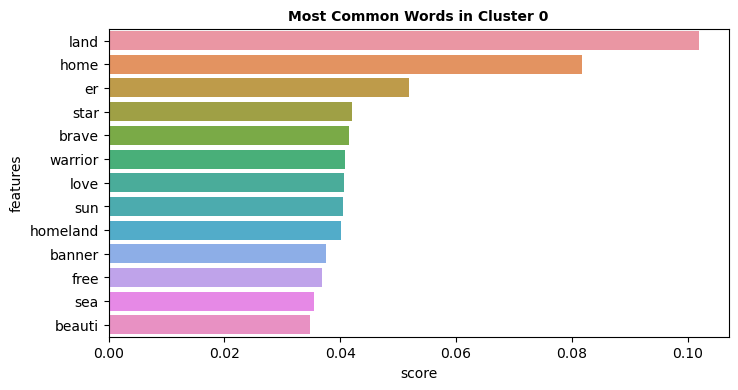

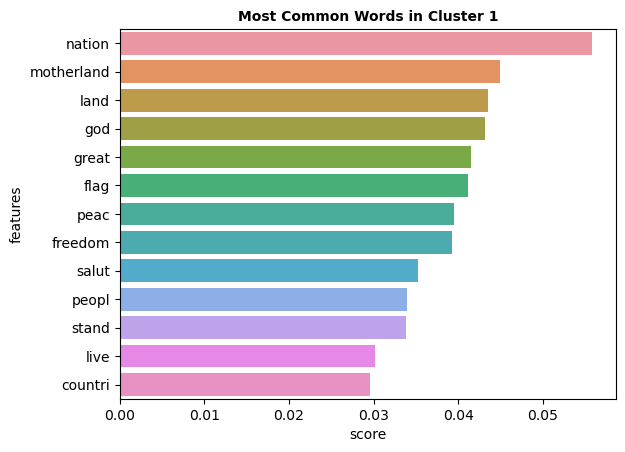

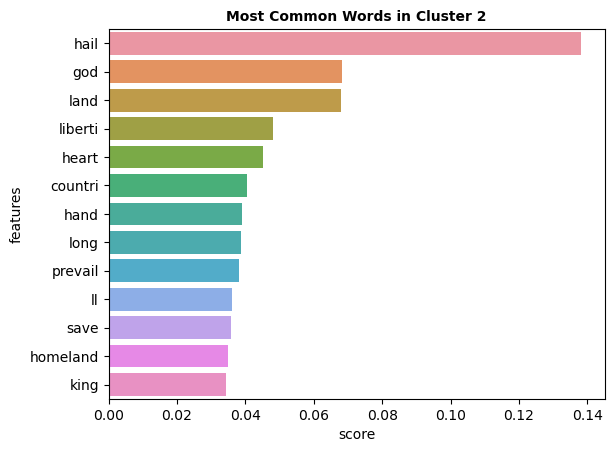

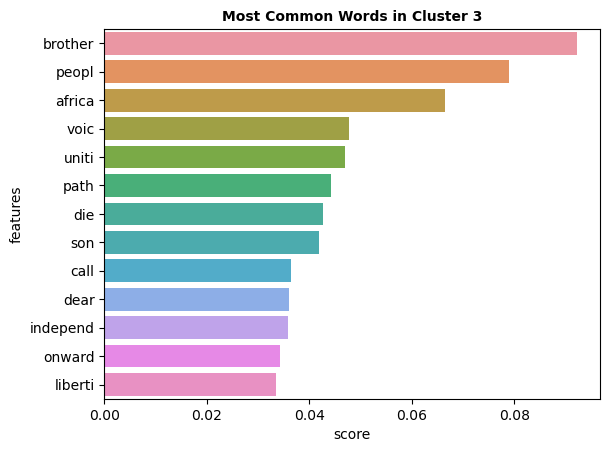

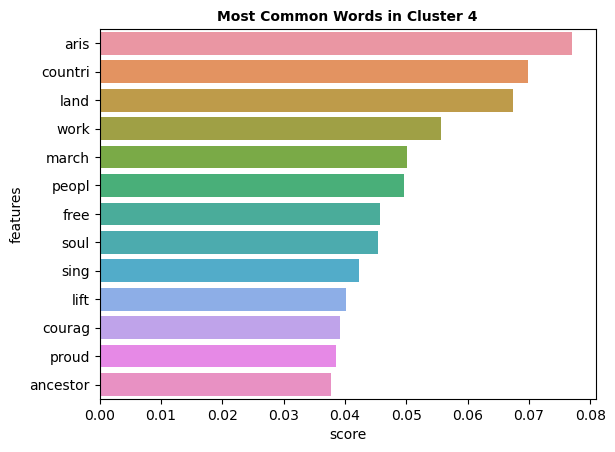

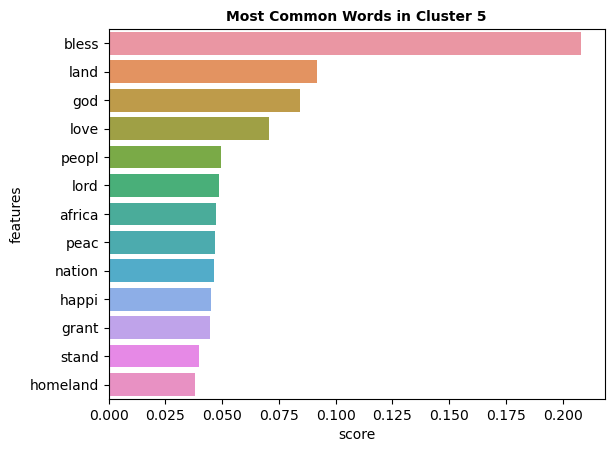

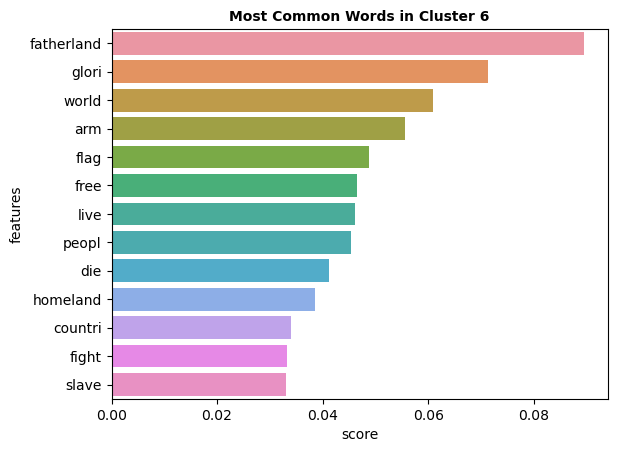

In [ ]:
n_features = 20
dfs = get_top_features_cluster(final_df_array, labels, n_features)
plotWords(dfs, 13)

In [ ]:
common_words=[]
for i in dfs:
    common_words.append(list(i['features'].values))

In [ ]:
# Assuming 'gmm' is the GMM model you want to use
labels_gmm = gmm.predict(final_df)

# Adding cluster labels to the DataFrame
data['label'] = labels_gmm

# Assuming 'common_words' is a list of common words for each GMM cluster
data['common_words'] = data['label'].map({0: common_words[0], 1: common_words[1], 2: common_words[2], 3: common_words[3], 4: common_words[4], 5: common_words[5], 6: common_words[6]})
data.head()

,country,alpha-2,alpha-3,continent,anthem,label,common_words
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",6,"[fatherland, glori, world, arm, flag, free, li..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",3,"[brother, peopl, africa, voic, uniti, path, di..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",0,"[land, home, er, star, brave, warrior, love, s..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",1,"[nation, motherland, land, god, great, flag, p..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",3,"[brother, peopl, africa, voic, uniti, path, di..."


In [ ]:
data['label'].unique()

array([6, 3, 0, 1, 2, 4, 5], dtype=int64)

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

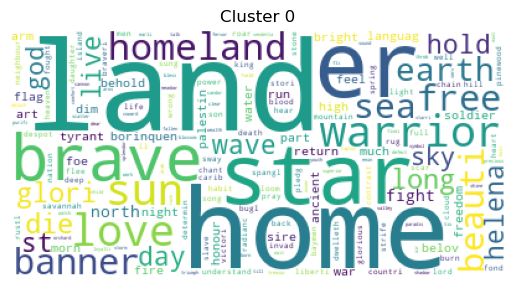

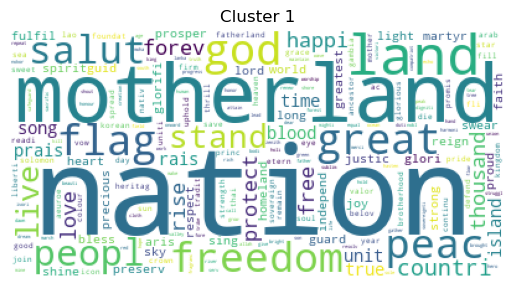

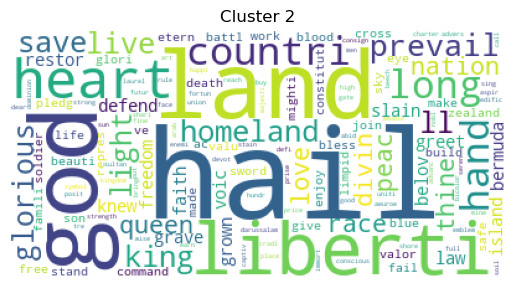

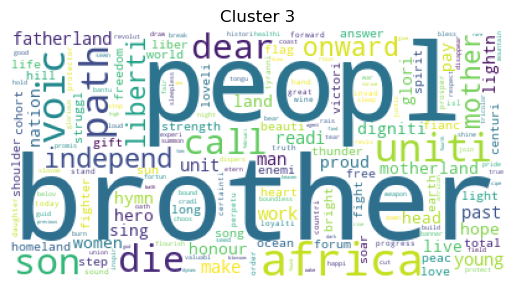

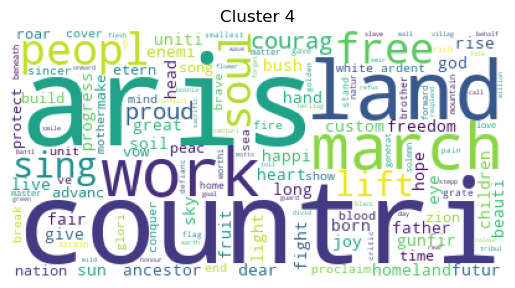

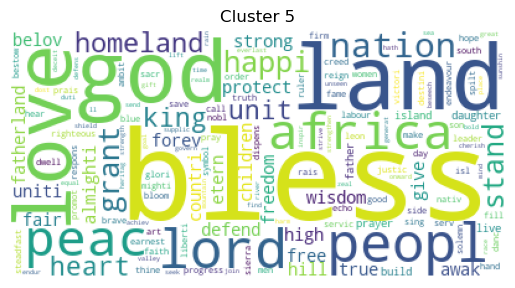

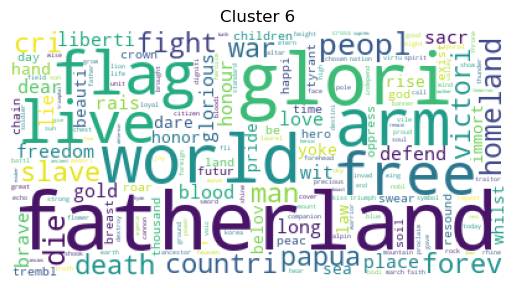

In [ ]:
centroids = pd.DataFrame(gmm.means_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [ ]:
# Assigning the cluster labels to each country
labels = labels_gmm
data['label'] = labels
data['common_words'] = data['label'].map({0:common_words[0],1:common_words[1],2:common_words[2],3:common_words[3],4:common_words[4],5:common_words[5],6:common_words[6]})
data['label_name'] = data['label'].map({0:"Home of the Warriors",1:"Sacred Motherland",2:"Land of Freedom and Liberty",3:"Patriotism and Brotherhood",4:"Imperial Millitary",5:"Blessed by the god",6:"Glory to the Fatherland"})
data.to_csv("./grouped_national_anthems.csv",index=False)
data.head()

,country,alpha-2,alpha-3,continent,anthem,label,common_words,label_name
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",6,"[fatherland, glori, world, arm, flag, free, li...",Glory to the Fatherland
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",3,"[brother, peopl, africa, voic, uniti, path, di...",Patriotism and Brotherhood
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",0,"[land, home, er, star, brave, warrior, love, s...",Home of the Warriors
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",1,"[nation, motherland, land, god, great, flag, p...",Sacred Motherland
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",3,"[brother, peopl, africa, voic, uniti, path, di...",Patriotism and Brotherhood


In [ ]:
data['label'].unique()

array([6, 3, 0, 1, 2, 4, 5], dtype=int64)

In [ ]:

# Loading countries polygons
geo_path = 'world-countries.json'
country_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)

# Merging on the alpha-3 country codes
merge = pd.merge(gpf, data, left_on='id', right_on='alpha-3')
data_to_plot = merge[["id", "name", "label","label_name", "geometry"]]

data_to_plot.head(5)

,id,name,label,label_name,geometry
0,AFG,Afghanistan,1,Sacred Motherland,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,AGO,Angola,3,Patriotism and Brotherhood,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,ALB,Albania,6,Glory to the Fatherland,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."
3,ARE,United Arab Emirates,4,Imperial Millitary,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,ARG,Argentina,6,Glory to the Fatherland,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000..."


In [ ]:
data_to_plot['label'].unique()

array([1, 3, 6, 4, 0, 2, 5], dtype=int64)

In [ ]:
import branca.colormap as cm

# Creating a discrete color map
values = data_to_plot[['label']].to_numpy()
color_step = cm.StepColormap(['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan'], vmin=values.min(), vmax=values.max(), caption='step')

color_step

In [ ]:
import folium
from branca.element import Figure

def make_geojson_choropleth(display, data, colors):
    '''creates geojson choropleth map using a colormap, with tooltip for country names and groups'''
    group_dict = data.set_index('id')['label'] # Dictionary of Countries IDs and Clusters
    tooltip = folium.features.GeoJsonTooltip(["name", "label_name"], aliases=display, labels=True)
    return folium.GeoJson(data[["id", "name","label_name","geometry"]],
                          style_function = lambda feature: {
                               'fillColor': colors(group_dict[feature['properties']['id']]),
                               #'fillColor': test(feature),
                               'color':'black',
                               'weight':0.5
                               },
                          highlight_function = lambda x: {'weight':2, 'color':'black'},
                          smooth_factor=2.0,
                          tooltip = tooltip)
# Makes map appear inline on notebook
def display(m, width, height):
    """Takes a folium instance and embed HTML."""
    fig = Figure(width=width, height=height)
    fig.add_child(m)
    #return fig

In [ ]:
# Initializing our Folium Map
m = folium.Map(location=[43.5775, -10.106111], zoom_start=2.3, tiles='cartodbpositron')

# Making a choropleth map with geojson
geojson_choropleth = make_geojson_choropleth(["Country:", "Group:"], data_to_plot, color_step)
geojson_choropleth.add_to(m)

width, height = 1300, 675
display(m, width, height)
m